In [ ]:
# Cargar los datos y obtener el modelo
from common import *
del iterate_over_rhs, perform_sensitivity_analysis # Aux temp
mdl, produccion_vars, products = create_model()
solve_model(mdl, produccion_vars, products)

Model: guia5problematipo2
 - number of variables: 3
   - binary=0, integer=0, continuous=3
 - number of constraints: 9
   - linear=9
 - parameters: defaults
 - objective: none
 - problem type is: LP
* Production model solved with objective: 5700
* Total benefit=5700
Production of A: 50.0
Production of B: 80.0
Production of C: 0


In [ ]:
#***Added by JL - 2024 Mar 03th - Checking sensitivity analysis *****')

# Initialize lists to store the results
rhs_values = []
objective_values = []

#real_rhs_value = 0

m = 0.01


In [ ]:
# Report values for the chart
### Aux: misma función que VM (cambian las listas nomás)

def report(rhs_value, obj):
    rhs_values.append(rhs_value)
    objective_values.append(obj)
    

In [ ]:
### ANTERIOR!!!
# # Perform sensitivity analysis of the RHS
# ### Aux: VM, Funcional, costo op
# aux: esta es la versión anterior, pero usa esto xq la iterate no es la refactorizada.
def perform_sensitivity_analysis(mdl):
    lp = LinearRelaxer.make_relaxed_model(mdl)
    lp.solve()
    cpx = lp.get_engine().get_cplex()

    return cpx.solution.sensitivity.rhs()

In [ ]:
# Iterate over RHS (from 0 to infinity) starting from current RHS value

def iterate_over_rhs(constraint_name):
    c = mdl.get_constraint_by_name(constraint_name)
    if c is None:
        print("Constraint with name '{0}' not found.".format(constraint_name))
        return
        
    # Perform initial sensitivity analysis to get the starting lower and upper bounds
    initial_sensitivity = perform_sensitivity_analysis(mdl)
    
    # Find the sensitivity range for the specified constraint
    for c_sens, (lower, upper) in zip(mdl.iter_constraints(), initial_sensitivity):
        if c_sens.name == constraint_name:
            
            # Report the real RHS value for the chart
            real_rhs_value = c_sens.rhs.constant
            report(real_rhs_value, mdl.objective_value)
        
            # *********Store and report the initial lower and upper bounds for the chart*********
            print("---Initial lower bound: {0}".format(lower))
            rhs = lower
            solution = solve(c, rhs, mdl, products, produccion_vars)
            if solution is not None:
                report(rhs, mdl.objective_value)

            print("---Initial upper bound: {0}".format(upper))
            rhs = upper
            solution = solve(c, rhs, mdl, products, produccion_vars)
            if solution is not None and rhs < mdl.infinity:
                report(rhs, mdl.objective_value)
            # ********* End of lower and upper bounds *********
            
            
            #Decrease rhs starting from lower bound - m
            rhs = lower - m
            while True:
                if rhs < 0:
                    break ## Stop if the rhs is lower than 0                
                
                solution = solve(c, rhs, mdl, products, produccion_vars)#+m) # aux: no son escalones, un "m" afecta al Z # TEMP # Da Timeout
                                        # claro, siempre obtengo el mismo rango xq me quedé en el inicial si
                                        # le vuevo a sumar el m que le resté, #ja.
                if solution is None:
                    break  # Stop if the model is infeasible
                
                #report(c_sens.rhs.constant+m, mdl.objective_value) ### AUX PROBANDO
                # Perform sensitivity analysis to get the new lower bound
                new_sensitivity = perform_sensitivity_analysis(mdl)                
                for c_new_sens, (new_lower, _) in zip(mdl.iter_constraints(), new_sensitivity):
                    if c_new_sens.name == constraint_name: 
                        rhs = new_lower
                        if rhs < 0:
                            break ## Stop if the rhs is lower than 0                
                            
                        solution = solve(c, rhs, mdl, products, produccion_vars)
                        if solution is None:
                            break  # Stop if the model is infeasible
                        report(c_new_sens.rhs.constant, mdl.objective_value)
                        
                        rhs = new_lower - m

                        break


            # Increase rhs starting from upper bound + m
            rhs = upper + m
            
            while True:
                if rhs >= mdl.infinity:
                    break ## Stop if the rhs reaches or exceeds infinity

                solution = solve(c, rhs, mdl, products, produccion_vars)#-m) # aux: no son escalones, un "m" afecta al Z # TEMP
                if solution is None:
                    break  # Stop if the model is infeasible

                #report(c_sens.rhs.constant-m, mdl.objective_value) ### AUX PROBANDO
                # Perform sensitivity analysis to get the new upper bound
                new_sensitivity = perform_sensitivity_analysis(mdl)
                for c_new_sens, (_, new_upper) in zip(mdl.iter_constraints(), new_sensitivity):
                    if c_new_sens.name == constraint_name:                        
                        rhs = new_upper
                        if rhs >= mdl.infinity:
                            break ## Stop if the rhs reaches or exceeds infinity

                        solution = solve(c, rhs, mdl, products, produccion_vars)
                        if solution is None:
                            break  # Stop if the model is infeasible
                        report(c_new_sens.rhs.constant, mdl.objective_value)
                        
                        rhs = new_upper + m

                        break
    return real_rhs_value

In [ ]:
# Usage of the iterate_over_rhs method
constraint_name = 'Disp_Equipo3'  # The name of the constraint to analyze
real_rhs_value = iterate_over_rhs(constraint_name)

---Initial lower bound: 80.0
---
Constraint with name 'Disp_Equipo3: 0.600produccion_A_50_100_0+produccion_B_40_120_80+0.600produccion_C_30_999999999999999_0 <= 110' not found.
---Initial upper bound: 140.0
---
Constraint with name 'Disp_Equipo3: 0.600produccion_A_50_100_0+produccion_B_40_120_80+0.600produccion_C_30_999999999999999_0 <= 110' not found.
---
Constraint with name 'Disp_Equipo3: 0.600produccion_A_50_100_0+produccion_B_40_120_80+0.600produccion_C_30_999999999999999_0 <= 110' not found.
---
Constraint with name 'Disp_Equipo3: 0.600produccion_A_50_100_0+produccion_B_40_120_80+0.600produccion_C_30_999999999999999_0 <= 110' not found.


In [ ]:
### Mejora1
# Armo pares y los ordeno según 'x'
pairs = []
for i in range(len(rhs_values)):
    pairs.append((rhs_values[i], objective_values[i]))

print("pairs", pairs)

#pairs.sort()
# Ordeno ascendentemente por la primera componente y Asc por la segunda si hay empates
pairs.sort(key=lambda x: (x[0], x[1]))

print("pairs", pairs)

# Los vuelvo a separar en listas, para no cambiar la función plot
new_rhs, new_obj = [], []
for elem in pairs:
    new_rhs.append(elem[0])
    new_obj.append(elem[1])
print("new_rhs", new_rhs)
print("new_dual", new_obj)

pairs [(110, 5700.0)]
pairs [(110, 5700.0)]
new_rhs [110]
new_dual [5700.0]


In [ ]:
### AUX
print(rhs_values)
print(objective_values)

[110]
[5700.0]


In [ ]:

def get_text_for_plot(xunit, yunit):   
    xlabel='{0}\n{1}'.format(constraint_name, xunit)
    ylabel='Funcional\n{}'.format(yunit)
    title='Funcional vs. {}'.format(constraint_name)

    return {"xlabel": xlabel, "ylabel": ylabel, "title": title}


[debug] current_x_value: 110


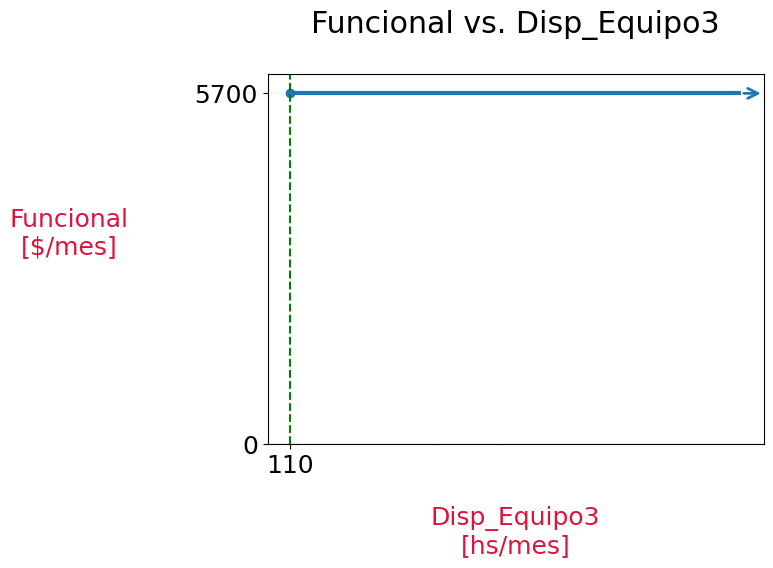

<Figure size 2000x1000 with 0 Axes>

In [ ]:
# Graficamos
plot_text = get_text_for_plot("[hs/mes]", "[$/mes]")
plot(new_rhs, new_obj, real_rhs_value, plot_text, False)